In [1]:
#Dataset Link : https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-price/data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.io as pio


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
pio.templates.default = "plotly_dark"

In [5]:
train = pd.read_csv("../Datasets/google/Google_Stock_Price_Train.csv", parse_dates=['Date'], index_col="Date")
train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.250,332.830,324.970,663.59,"7,380,500"
2012-01-04,331.270,333.870,329.080,666.45,"5,749,400"
2012-01-05,329.830,330.750,326.890,657.21,"6,590,300"
2012-01-06,328.340,328.770,323.680,648.24,"5,405,900"
2012-01-09,322.040,322.290,309.460,620.76,"11,688,800"


In [6]:
test = pd.read_csv("../datasets/google/Google_Stock_Price_Test.csv", parse_dates=['Date'], index_col="Date")
test.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.810,789.630,775.800,786.140,"1,657,300"
2017-01-04,788.360,791.340,783.160,786.900,"1,073,000"
2017-01-05,786.080,794.480,785.020,794.020,"1,335,200"
2017-01-06,795.260,807.900,792.200,806.150,"1,640,200"
2017-01-09,806.400,809.970,802.830,806.650,"1,272,400"


In [7]:
train.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
test.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Close   1258 non-null   object
dtypes: object(1)
memory usage: 19.7+ KB


In [9]:
train['Close'] = train['Close'].str.replace(',', '').astype(float)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   20 non-null     float64
dtypes: float64(1)
memory usage: 320.0 bytes


In [11]:
train.isnull().sum()

Close    0
dtype: int64

In [12]:
test.isnull().sum()

Close    0
dtype: int64

In [13]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1258.000,712.670,164.753,491.200,576.740,695.675,782.105,1216.830


In [18]:
print("Training data shape : ", train.shape)
print("Testing data shape : ", test.shape)

Training data shape :  (1258, 1)
Testing data shape :  (20, 1)


Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()


In [20]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [22]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [23]:
len(generator)

1246

In [24]:
generator[0]

(array([[[0.23757287],
         [0.24151427],
         [0.22878051],
         [0.21641884],
         [0.1785483 ],
         [0.17947163],
         [0.18335791],
         [0.18841558],
         [0.18202114],
         [0.18695478],
         [0.19290823],
         [0.2020589 ]]]),
 array([[0.12842633]]))

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [26]:
train_scaled.shape

(1258, 1)

In [27]:
n_features = train_scaled.shape[1]
n_features

1

In [28]:
from keras.layers import Dropout

model = Sequential()
model.add(SimpleRNN(units=128, activation="tanh", input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(64, activation="tanh"))
model.add(Dense(32, activation="tanh"))  
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 27,009
Trainable params: 27,009
Non-trainable params: 0
_________________________________________________________________


In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)


In [31]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)


In [32]:
model.fit(generator,
            epochs = 30,
            validation_data = validation_generator,
            callbacks = [early_stop])

Epoch 1/30
1246/1246 [==============================] - 9s 5ms/step - loss: 0.0053 - val_loss: 5.7328e-04
Epoch 2/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0019 - val_loss: 8.2371e-04
Epoch 3/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0025 - val_loss: 2.3772e-04
Epoch 4/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0019 - val_loss: 2.6947e-04
Epoch 5/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 1.3822e-04
Epoch 6/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 8/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0018 - val_loss: 6.6195e-04
Epoch 9/30
1246/1246 [==============================] - 6s 5ms/step - loss: 0.0017 - val_loss: 3.6938e-04
Epoch 10/30
1246/1246 [==============================]

<Axes: >

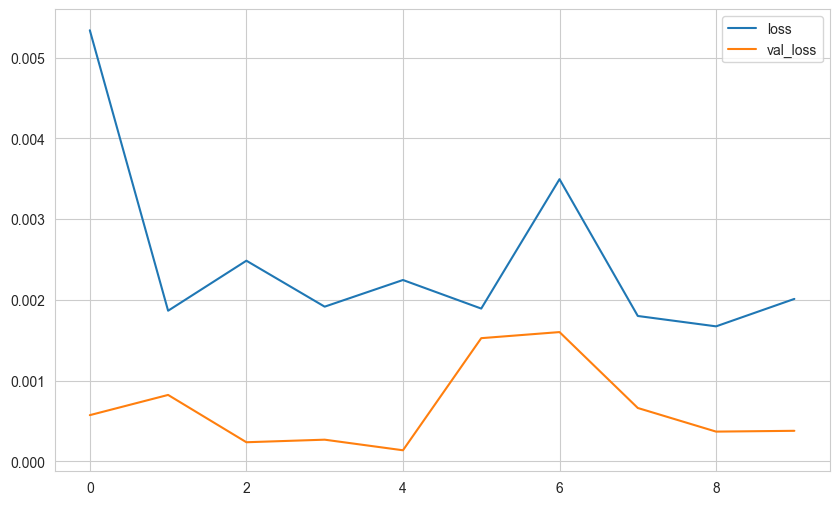

In [33]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [35]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    return print("\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [36]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 40ms/step


In [37]:
current_pred

array([[0.44435918]], dtype=float32)

In [38]:
current_batch


array([[[0.38959938],
        [0.39719534],
        [0.40967798],
        [0.41821384],
        [0.42642248],
        [0.43123269],
        [0.43519372],
        [0.43801856],
        [0.44149083],
        [0.44337869],
        [0.44490635],
        [0.44435918]]])

In [39]:
predictions_scaled


[array([0.38959938], dtype=float32),
 array([0.39719534], dtype=float32),
 array([0.40967798], dtype=float32),
 array([0.41821384], dtype=float32),
 array([0.42642248], dtype=float32),
 array([0.4312327], dtype=float32),
 array([0.43519372], dtype=float32),
 array([0.43801856], dtype=float32),
 array([0.44149083], dtype=float32),
 array([0.4433787], dtype=float32),
 array([0.44490635], dtype=float32),
 array([0.44435918], dtype=float32)]

In [40]:
eval_metrics(test_scaled[:length], predictions_scaled)



mae: 0.009012868106210456 
mse: 0.00010933637405144733 
rmse: 0.010456403495057338


In [41]:
predictions = scaler.inverse_transform(predictions_scaled)


In [42]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Close,Predictions_tanh
Date,,
2017-01-03,786.140,773.905
2017-01-04,786.900,779.417
2017-01-05,794.020,788.475
2017-01-06,806.150,794.669
2017-01-09,806.650,800.625
2017-01-10,804.790,804.115
2017-01-11,807.910,806.990
2017-01-12,806.360,809.039
2017-01-13,807.880,811.559


<Axes: xlabel='Date'>

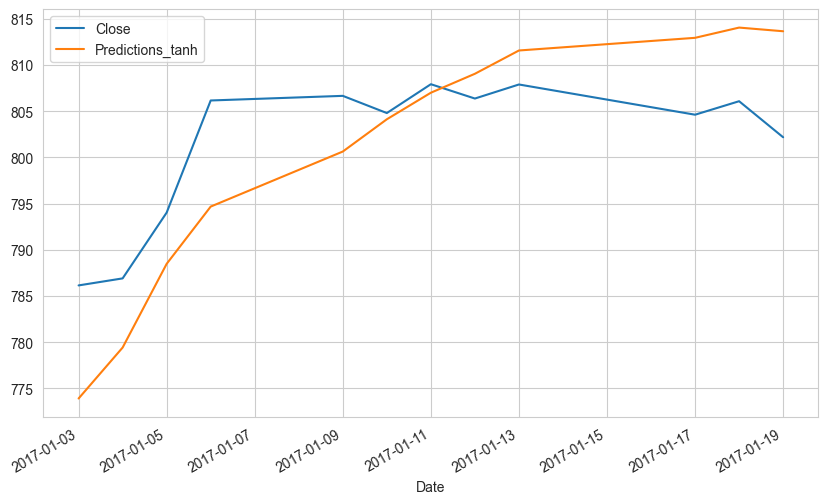

In [43]:
compare.plot()

In [44]:
eval_metrics(compare.Close, compare.Predictions_tanh)



mae: 6.5400074839095055 
mse: 57.569853784095265 
rmse: 7.5874800681184835


In [45]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [47]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)


In [48]:
model.fit(generator,
            epochs = 30,
            validation_data = validation_generator,
            callbacks = [early_stop])

Epoch 1/30
1246/1246 [==============================] - 25s 16ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 2/30
1246/1246 [==============================] - 18s 15ms/step - loss: 0.0039 - val_loss: 5.6865e-04
Epoch 3/30
1246/1246 [==============================] - 19s 15ms/step - loss: 0.0053 - val_loss: 0.0253
Epoch 4/30
1246/1246 [==============================] - 19s 15ms/step - loss: 0.0035 - val_loss: 8.6075e-04
Epoch 5/30
1246/1246 [==============================] - 20s 16ms/step - loss: 0.0024 - val_loss: 6.7124e-04
Epoch 6/30
1246/1246 [==============================] - 20s 16ms/step - loss: 0.0022 - val_loss: 5.7382e-04
Epoch 7/30
1246/1246 [==============================] - 19s 15ms/step - loss: 0.0019 - val_loss: 6.3861e-04


<Axes: >

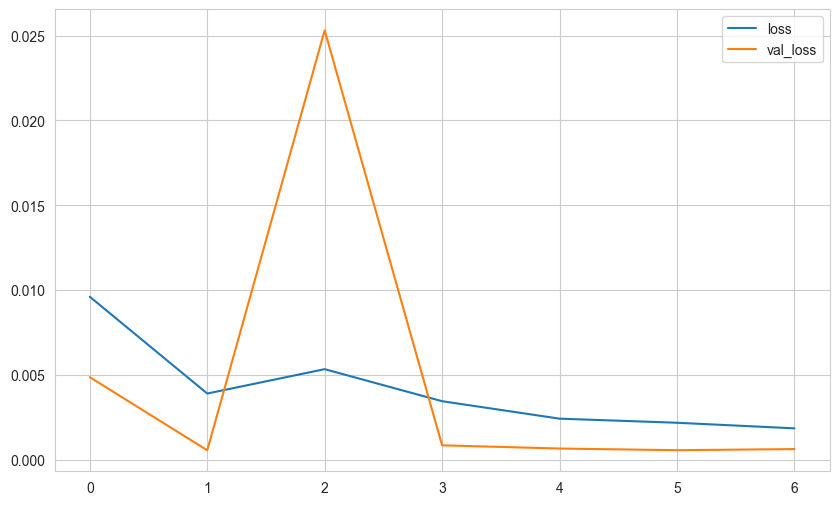

In [49]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [50]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 37ms/step


In [51]:
predictions = scaler.inverse_transform(predictions_scaled)


In [52]:
compare['Predictions_relu'] = predictions
compare

,Close,Predictions_tanh,Predictions_relu
Date,,,
2017-01-03,786.140,773.905,791.576
2017-01-04,786.900,779.417,789.818
2017-01-05,794.020,788.475,788.755
2017-01-06,806.150,794.669,788.120
2017-01-09,806.650,800.625,787.740
2017-01-10,804.790,804.115,787.630
2017-01-11,807.910,806.990,788.080
2017-01-12,806.360,809.039,788.779
2017-01-13,807.880,811.559,789.634


<Axes: xlabel='Date'>

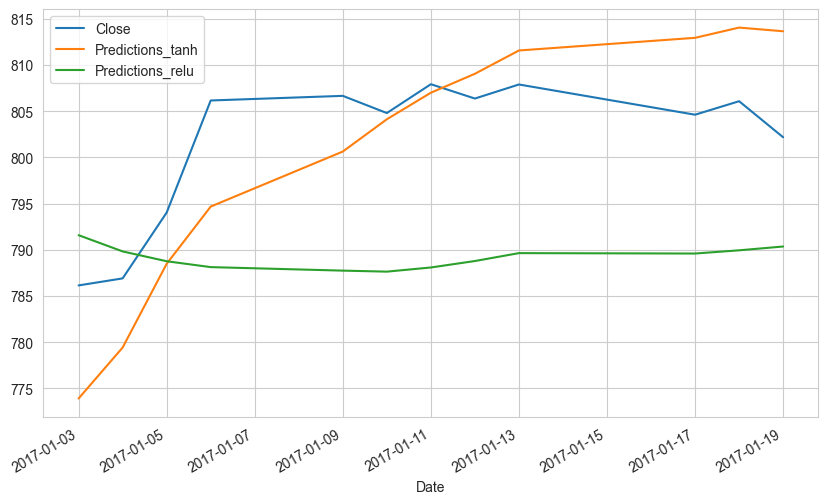

In [53]:
compare.plot()


In [54]:
eval_metrics(compare.Close, compare.Predictions_relu)



mae: 13.862489256585633 
mse: 225.31431107537404 
rmse: 15.01047337945656


In [55]:
full_data = pd.concat([train, test])


In [56]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(full_data)

In [57]:
full_data.head()


,Close
Date,
2012-01-03,663.590
2012-01-04,666.450
2012-01-05,657.210
2012-01-06,648.240
2012-01-09,620.760


In [58]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [59]:
len(full_data)

1278

In [60]:
len(generator)

1266

In [61]:
# Initialising the RNN
model = Sequential()

# Adding the first RNN layer and some Dropout regularisation
model.add(SimpleRNN(units = 50,activation='relu', return_sequences = True, input_shape = (length, n_features)))
model.add(Dropout(0.2)) 
# Adding a second RNN layer and some Dropout regularisation.
model.add(SimpleRNN(units = 50,activation='relu', return_sequences = True))
model.add(Dropout(0.2))
# Adding a third RNN layer and some Dropout regularisation. 
model.add(SimpleRNN(units = 50,activation='relu', return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth RNN layer and some Dropout regularisation.
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

# Fitting the RNN to the Training set
model.fit(generator, epochs = 40, batch_size = 32)

Epoch 1/40
1266/1266 [==============================] - 24s 14ms/step - loss: 0.0179
Epoch 2/40
1266/1266 [==============================] - 18s 14ms/step - loss: 0.0092
Epoch 3/40
1266/1266 [==============================] - 17s 14ms/step - loss: 0.0073
Epoch 4/40
1266/1266 [==============================] - 17s 13ms/step - loss: 0.0075
Epoch 5/40
1266/1266 [==============================] - 18s 14ms/step - loss: 0.0067
Epoch 6/40
1266/1266 [==============================] - 17s 14ms/step - loss: 0.0065
Epoch 7/40
1266/1266 [==============================] - 17s 14ms/step - loss: 0.0046
Epoch 8/40
1266/1266 [==============================] - 17s 13ms/step - loss: 0.0049
Epoch 9/40
1266/1266 [==============================] - 18s 14ms/step - loss: 0.0048
Epoch 10/40
1266/1266 [==============================] - 18s 14ms/step - loss: 0.0044
Epoch 11/40
1266/1266 [==============================] - 17s 14ms/step - loss: 0.0042
Epoch 12/40
1266/1266 [==============================] - 18s 14

In [62]:
model = Sequential()

model.add(SimpleRNN(units=128, activation="tanh", input_shape=(length, n_features)))
model.add(Dropout(0.2))  
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="tanh"))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

model.fit(generator, epochs=30)

Epoch 1/30
1266/1266 [==============================] - 8s 5ms/step - loss: 0.0054
Epoch 2/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0024
Epoch 3/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0024
Epoch 4/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0029
Epoch 5/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0020
Epoch 6/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0021
Epoch 7/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0028
Epoch 8/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0020
Epoch 9/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0017
Epoch 10/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0019
Epoch 11/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0023
Epoch 12/30
1266/1266 [==============================] - 6s 5ms/step - loss: 0.0018
E

In [63]:
forecast = []
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 36ms/step


In [64]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947],
       [803.44606947]])

In [65]:
full_data


,Close
Date,
2012-01-03,663.590
2012-01-04,666.450
2012-01-05,657.210
2012-01-06,648.240
2012-01-09,620.760
...,...
2017-01-25,835.670
2017-01-26,832.150
2017-01-27,823.310


In [66]:
test.head()


,Close
Date,
2017-01-03,786.140
2017-01-04,786.900
2017-01-05,794.020
2017-01-06,806.150
2017-01-09,806.650


In [67]:
forecast_index = pd.date_range(start = '2014-03-27', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01'],
              dtype='datetime64[ns]', freq='MS')

In [68]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2014-04-01,803.446
2014-05-01,803.446
2014-06-01,803.446
2014-07-01,803.446
2014-08-01,803.446
2014-09-01,803.446
2014-10-01,803.446
2014-11-01,803.446
2014-12-01,803.446
2015-01-01,803.446


In [69]:
train['2014':'2015'][train['Close'] < 1200].reset_index().head(45)


,Date,Close
0,2014-01-02,1110.070
1,2014-01-03,1101.970
2,2014-01-06,1114.260
3,2014-01-07,1135.740
4,2014-01-08,1138.110
5,2014-01-09,1127.150
6,2014-01-10,1127.090
7,2014-01-13,1119.910
8,2014-01-14,1146.250
9,2014-01-15,1145.480


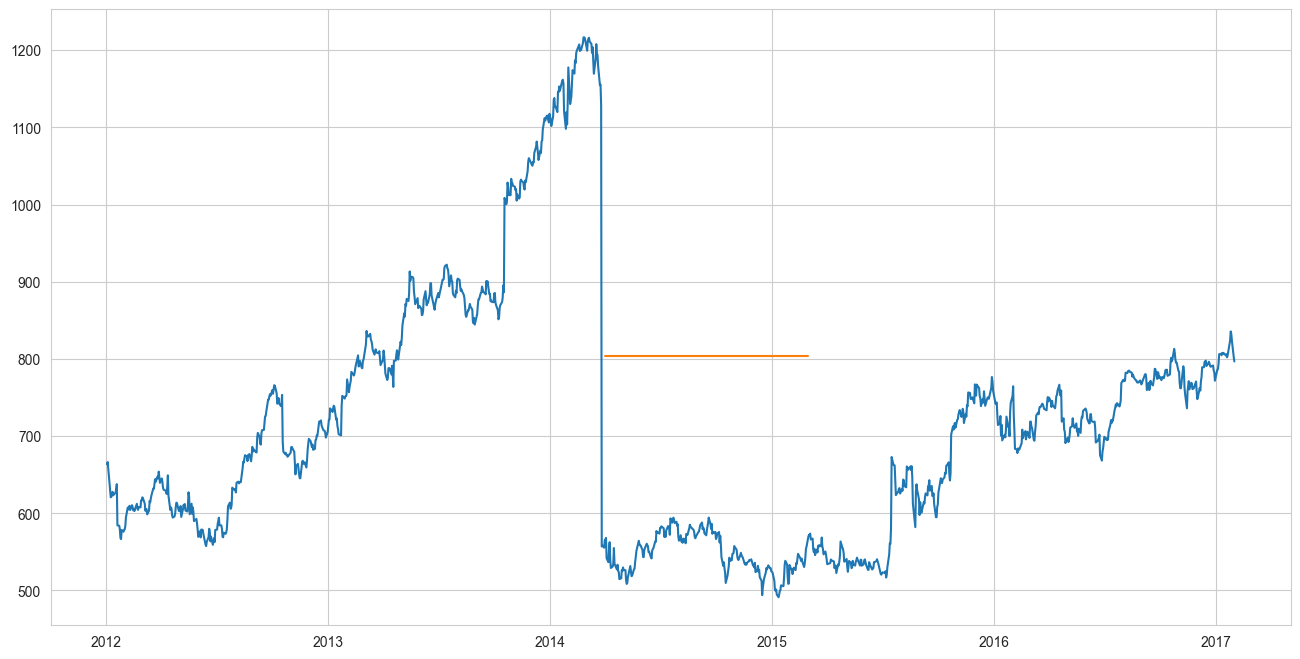

In [70]:
plt.figure(figsize = (16, 8))
plt.plot(full_data.index, full_data['Close'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

In [71]:
test.head()


,Close
Date,
2017-01-03,786.140
2017-01-04,786.900
2017-01-05,794.020
2017-01-06,806.150
2017-01-09,806.650


In [72]:
forecast_index = pd.date_range(start = '2017-01-03', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [73]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2017-02-01,803.446
2017-03-01,803.446
2017-04-01,803.446
2017-05-01,803.446
2017-06-01,803.446
2017-07-01,803.446
2017-08-01,803.446
2017-09-01,803.446
2017-10-01,803.446
2017-11-01,803.446


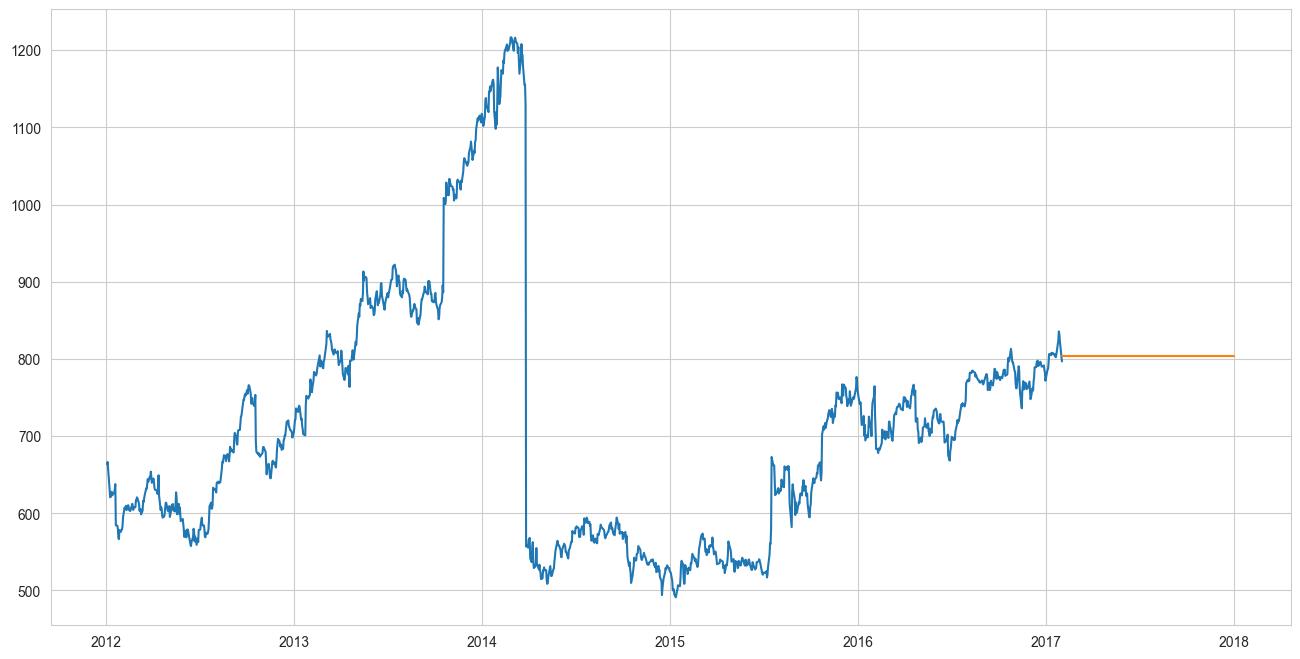

In [74]:
plt.figure(figsize = (16, 8))
plt.plot(full_data.index, full_data['Close'])
plt.plot(forecast_df.index, forecast_df['Forecast'])